# Case Study: Compositional Inference for a Drift Diffusion Model

Consider a decision task in which participants are presented with sequences of letters and asked
to differentiate between words and non-words (i.e., a lexical decision task). The Diffusion Decision Model (DDM;
e.g., Ratcliff et al., 2016) simulataneously models this binary decision and the response time via a continuous evidence
accumulation process: After an initial non-decision time t0, evidence accumulates following a noisy diffusion process
with a certain drift rate ν, starting from a point β, until one of two decision thresholds {0,α}corresponding to the two
choices is hit.

\begin{align*}
\nu_j\sim\mathcal{N}(0.5,\exp(-1)) \\
\log \alpha_j\sim\mathcal{N}(0,\exp(-3)) \\
\log t_{0,j}\sim\mathcal{N}(-1,\exp(-1)) \\
\beta_j\sim\operatorname{Beta}(a=50,b=50) \\
y_j\sim \operatorname{DDM}(\nu_j,\alpha_j,t_{0,j},\beta_j)
\end{align*}
$\beta_\text{raw}$ is a transformed unbounded variable that is transformed to $\beta$ via the beta inverse CDF.


In [1]:
import os
if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np
import matplotlib.pyplot as plt
import pickle

import keras
import bayesflow as bf

from ddm_simulator import simulate_ddm, beta_from_normal

problem_name = "compositional_case_study"
storage = '' #f'plots/{problem_name}/'
n_jobs = 10 #int(os.environ.get('SLURM_CPUS_PER_TASK', 1))

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [2]:
param_names = ['nu', 'log_alpha', 'log_t0', 'beta_raw']
pretty_param_names = [r'$\nu$', r'$\log \alpha$', r'$\log t_0$', r'$\beta_\text{raw}$']
pretty_param_names_p = [r'$\nu_p$', r'$\log \alpha_p$', r'$\log t_{0,p}$', r'$\beta_p$']
num_training_batches = 256
num_validation_sets = 300
batch_size = 128
epochs = 1000

In [3]:
# ---------------------------
# Priors
# ---------------------------
def sample_priors():
    # Subject level
    nu = np.random.normal(0.5, np.exp(-1.0))
    log_alpha = np.random.normal(0.0, np.exp(-3.0))
    log_t0 = np.random.normal(-1.0, np.exp(-1.0))

    #beta = np.random.beta(a=50, b=50)
    beta_raw = np.random.normal(0.0, 1.0)
    beta = beta_from_normal(beta_raw, a=50, b=50)

    return {
        "nu": nu,
        "log_alpha": log_alpha,
        "alpha": np.exp(log_alpha),
        "log_t0": log_t0,
        "t0": np.exp(log_t0),
        "beta_raw": beta_raw,
        "beta": beta,
    }

def score_log_norm(x, m, s):
    return -(x - m) / s**2

def prior_score(x: dict):
    nu = x["nu"]
    log_alpha = x["log_alpha"]
    log_t0 = x["log_t0"]
    beta_raw = x["beta_raw"]

    parts = {
        "nu": score_log_norm(nu, m=0.5, s=np.exp(-1.0)),
        "log_alpha": score_log_norm(log_alpha, m=0.0, s=np.exp(-3.0)),
        "log_t0": score_log_norm(log_t0, m=-1.0, s=np.exp(-1.0)),
        "beta_raw":  score_log_norm(beta_raw, m=0.0, s=1.0)
    }
    return parts

simulator = bf.make_simulator([sample_priors, simulate_ddm])
print(simulator.sample(1)['sim_data'].shape)

(1, 2)


In [4]:
few_trials = 30
training_data_trials = None #simulator.sample_parallel((num_training_batches * batch_size), n_trials=few_trials)
validation_data_trials = simulator.sample_parallel(num_validation_sets, n_trials=few_trials)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you 

In [5]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .concatenate(param_names, into="inference_variables")
    .rename("sim_data", "summary_variables")
)

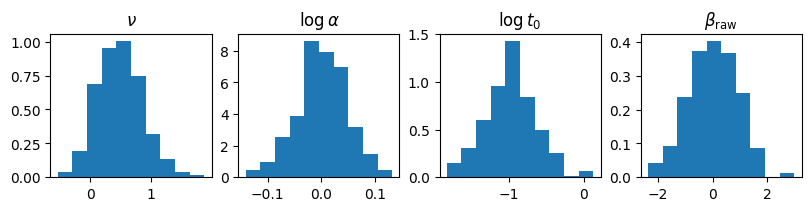

(300, 4)


In [6]:
# check how the distributions look like
test_params = adapter.forward(validation_data_trials)['inference_variables']

n_rows = len(param_names) // 4
n_cols = int(np.ceil(len(param_names) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows), layout='constrained')
ax = ax.flatten()
for i, name in enumerate(pretty_param_names):
    samples = test_params[:, i]
    ax[i].hist(samples, density=True)
    ax[i].set_title(name)
plt.show()

print(test_params.shape)

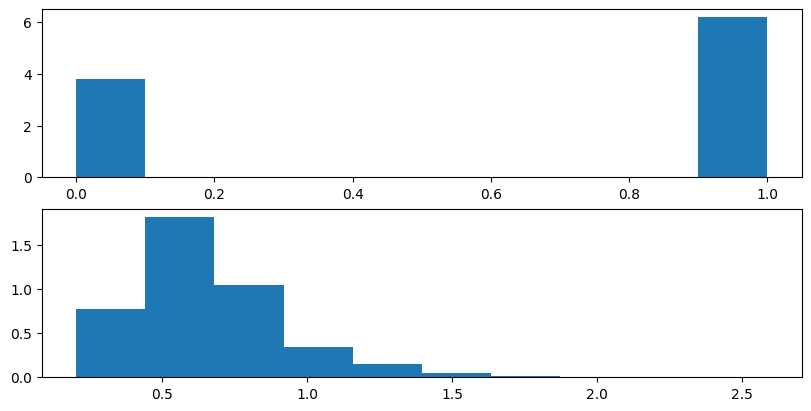

(300, 30, 2)


In [7]:
# check how the data distribution looks like
test_data = adapter.forward(validation_data_trials)['summary_variables']
n_features = test_data.shape[-1]

fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(n_features / 2)), figsize=(8, 4), layout='constrained')
ax = ax.flatten()
for i in range(n_features):
    ax[i].hist(test_data[..., i].flatten(), density=True)
plt.show()

print(test_data.shape)

# No Pooling
 trained on few trials, compositional inference over trials for the same subject

In [8]:
workflow_trials = bf.BasicWorkflow(
    adapter=adapter,
    summary_network=bf.networks.SetTransformer(summary_dim=16, dropout=0.1),
    inference_network=bf.networks.CompositionalDiffusionModel(),
)

In [53]:
model_path = f'{storage}models/pooling_few_trial_{few_trials}.keras'
if not os.path.exists(model_path):
    history = workflow_trials.fit_offline(
        training_data_trials,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data_trials,
        verbose=2,
    )
    workflow_trials.approximator.save(model_path)
else:
    workflow_trials.approximator = keras.models.load_model(model_path)

In [54]:
# diagnostics_plots = workflow_trials.plot_default_diagnostics(test_data=validation_data_trials, num_samples=100,
#                                                              calibration_ecdf_kwargs={"difference": True},
#                                                              variable_names=pretty_param_names)
#for k in diagnostics_plots.keys():
#    diagnostics_plots[k].savefig(f"{storage}plots/pooling_few_trial_{k}.png")

In [55]:
ps = workflow_trials.sample(conditions=validation_data_trials, num_samples=100)
ps['beta'] = beta_from_normal(ps['beta_raw'], a=50, b=50)
ps.pop('beta_raw');

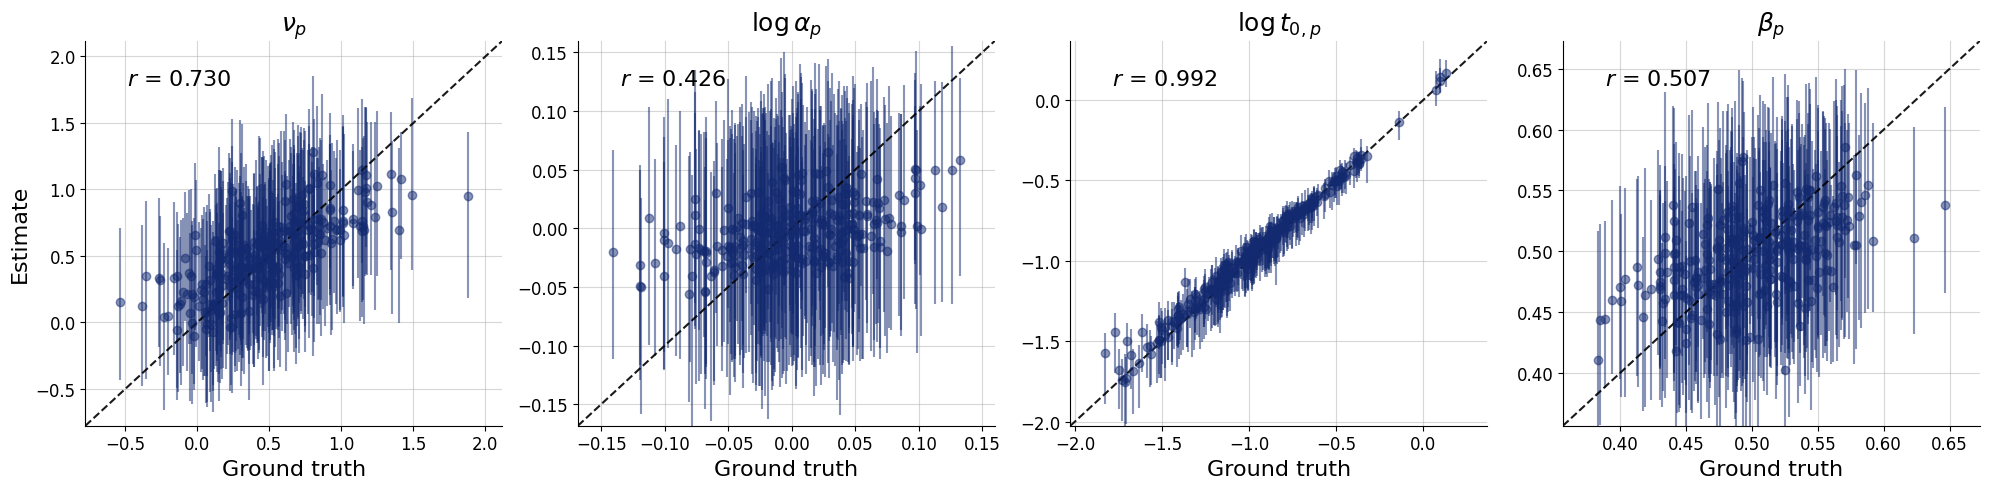

In [56]:
fig = bf.diagnostics.recovery(
    estimates=ps,
    targets=validation_data_trials,
    variable_names=pretty_param_names_p
)
#fig.savefig(f"{storage}plots/pooling_few_trial_recovery_{few_trials}.png")

In [57]:
ps['alpha'] = np.exp(ps['log_alpha'])
ps['t0'] = np.exp(ps['log_t0'])
metrics = {
    'NRMSE': bf.diagnostics.metrics.root_mean_squared_error(ps, validation_data_trials)['values'][[0,4,5,3]],
    'calibration_error': bf.diagnostics.metrics.calibration_error(ps, validation_data_trials)['values'][[0,4,5,3]],
    'calibration_log_gamma': bf.diagnostics.metrics.calibration_log_gamma(ps, validation_data_trials)['values'][[0,4,5,3]],
}

with open(f'complete_pooling_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
metrics

{'NRMSE': VariableArray([0.16670042, 0.24476051, 0.03208247, 0.22515351]),
 'calibration_error': VariableArray([0.0772807 , 0.03947368, 0.2027193 , 0.03175439]),
 'calibration_log_gamma': array([-8.20180806, -2.93932759,        -inf, -0.42239183])}

## Compositional inference over trials

In [21]:
n_trials = 30
n_datasets = num_validation_sets
test_data_comp_trials = simulator.sample_parallel(n_datasets, n_trials=n_trials)
validation_data_trials['sim_data'].shape, test_data_comp_trials['sim_data'].shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 281 out of 300 | elapsed:    1.6s remaining:    0.1s
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom 

((300, 30, 2), (300, 30, 2))

In [46]:
print('n compositional scores:', n_trials//few_trials)
test_posterior_comp_trials = workflow_trials.compositional_sample(
    num_samples=100,
    conditions={
        'sim_data': test_data_comp_trials['sim_data'][:, None].reshape(
            n_datasets, n_trials//few_trials, few_trials, 2)
    },
    compute_prior_score=prior_score,
    steps=200,
    #corrector_steps=1,
    #step_size_factor=0.01,
    #compositional_bridge_d1=0.001,
    #compositional_bridge_d0=0.01,
    mini_batch_size=1
)

test_posterior_comp_trials['beta'] = beta_from_normal(test_posterior_comp_trials['beta_raw'], a=50, b=50)
test_posterior_comp_trials.pop('beta_raw');

n compositional scores: 1


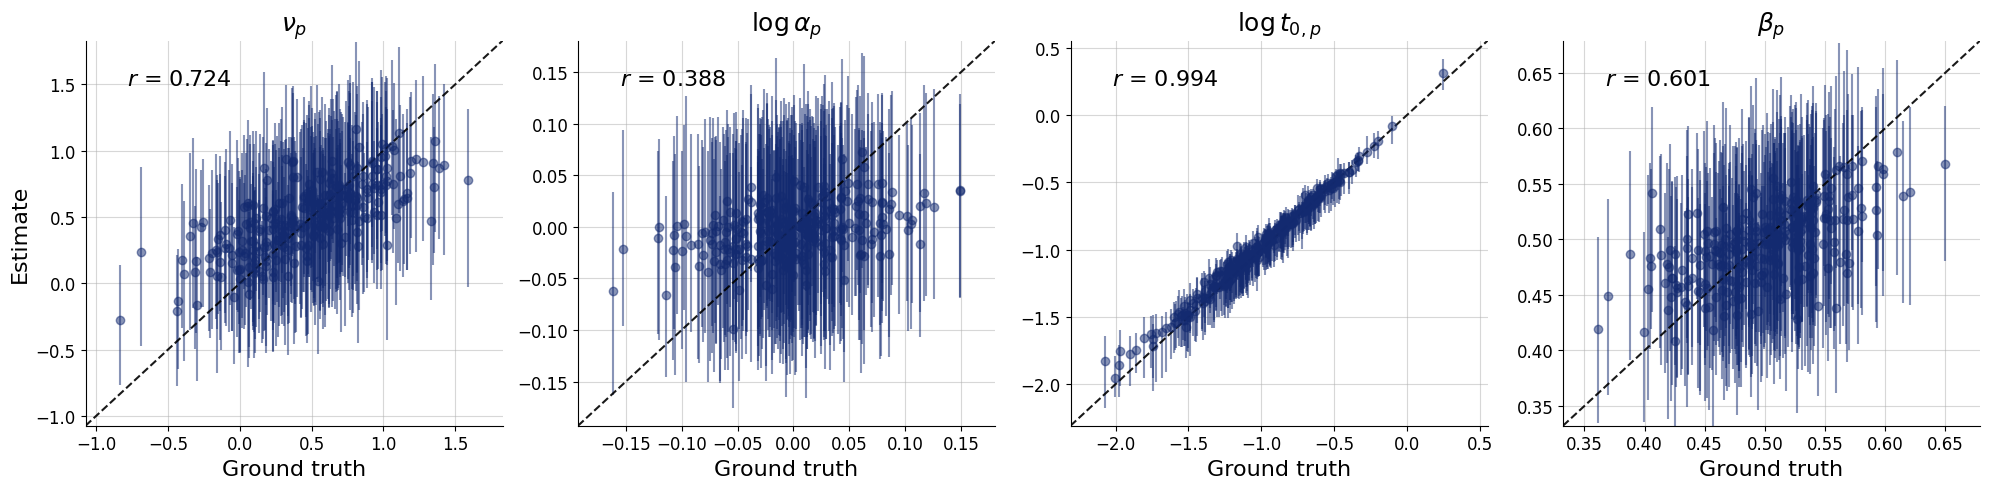

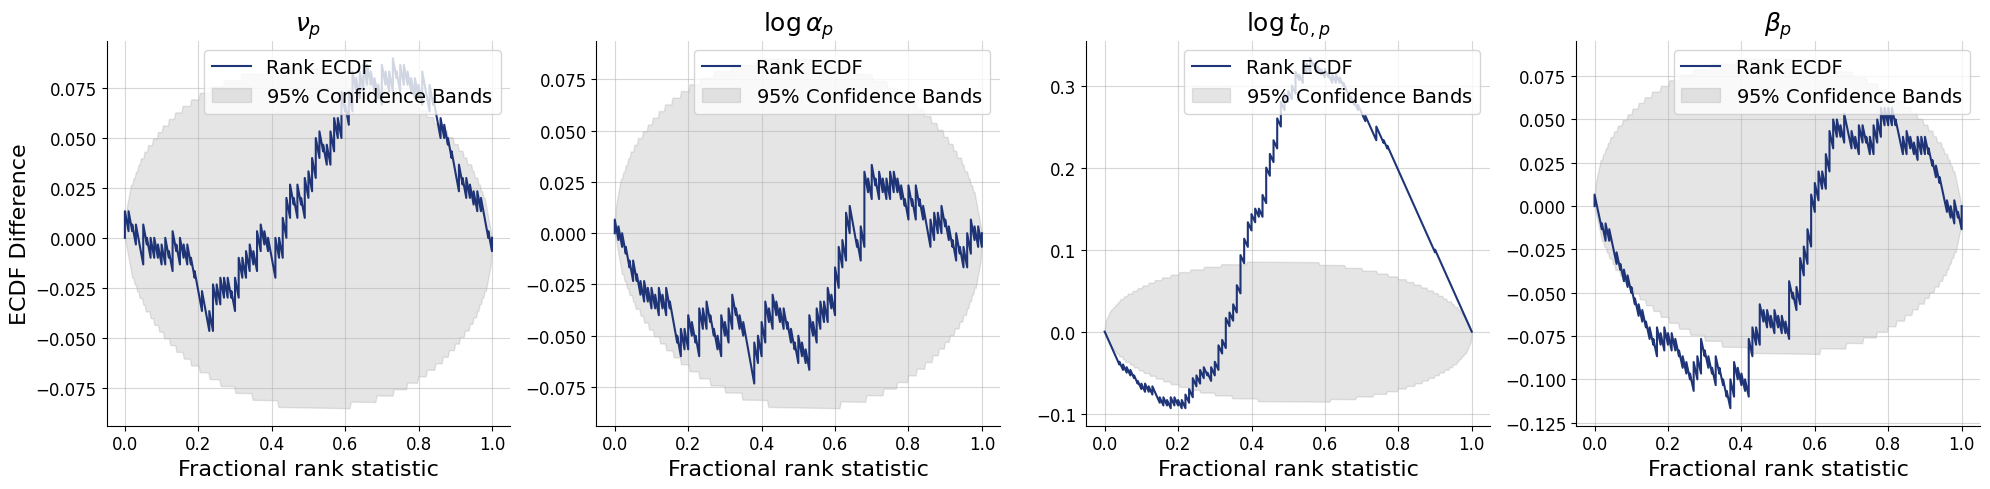

In [47]:
fig = bf.diagnostics.recovery(
    estimates=test_posterior_comp_trials,
    targets=test_data_comp_trials,
    variable_names=pretty_param_names_p
)
#fig.savefig(f"{storage}plots/pooling_compositional_trials_recovery_{few_trials}.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=test_posterior_comp_trials,
    targets=test_data_comp_trials,
    difference=True,
    variable_names=pretty_param_names_p
)
# fig.savefig(f"{storage}plots/pooling_compositional_trials_calibration.png")

In [50]:
bf.diagnostics.metrics.root_mean_squared_error(test_posterior_comp_trials, test_data_comp_trials)

{'values': VariableArray([0.17777669, 0.22593936, 0.04054578, 0.20712859, 0.22634338,
                0.02835339]),
 'metric_name': 'NRMSE',
 'variable_names': ['nu', 'log_alpha', 'log_t0', 'beta', 'alpha', 't0']}

In [52]:
test_posterior_comp_trials['alpha'] = np.exp(test_posterior_comp_trials['log_alpha'])
test_posterior_comp_trials['t0'] = np.exp(test_posterior_comp_trials['log_t0'])
metrics = {
    'NRMSE': bf.diagnostics.metrics.root_mean_squared_error(test_posterior_comp_trials, test_data_comp_trials)['values'][[0,4,5,3]],
    'calibration_error': bf.diagnostics.metrics.calibration_error(test_posterior_comp_trials, test_data_comp_trials)['values'][[0,4,5,3]],
    'calibration_log_gamma': bf.diagnostics.metrics.calibration_log_gamma(test_posterior_comp_trials, test_data_comp_trials)['values'][[0,4,5,3]],
}

with open(f'complete_pooling_trials_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
metrics

{'NRMSE': VariableArray([0.17777669, 0.22634338, 0.02835339, 0.20712859]),
 'calibration_error': VariableArray([0.06096491, 0.0322807 , 0.19105263, 0.1027193 ]),
 'calibration_log_gamma': array([-2.57885157,  1.23418197,        -inf, -4.41810349])}

# Complete Pooling

## Compositional inference over subjects

In [25]:
n_subjects = 30
n_datasets = num_validation_sets
test_data_comp_subjects = simulator.sample_parallel(n_datasets, n_subjects=n_subjects, n_trials=n_trials)
validation_data_trials['sim_data'].shape, test_data_comp_subjects['sim_data'].shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
INFO:bayesflow:Using backend 'torch'
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you 

((300, 30, 2), (300, 30, 30, 2))

In [58]:
print('n compositional scores:', n_subjects*n_trials//few_trials)
test_posterior_comp_subjects = workflow_trials.compositional_sample(
    num_samples=100,
    conditions={
        'sim_data': test_data_comp_subjects['sim_data'][:, None].reshape(
            n_datasets, n_subjects*n_trials//few_trials, few_trials, 2)
    },
    compute_prior_score=prior_score,
    steps=200,
    corrector_steps=1,
    #step_size_factor=0.01,
    compositional_bridge_d1=0.01,
    mini_batch_size=1
)
test_posterior_comp_subjects['beta'] = beta_from_normal(test_posterior_comp_subjects['beta_raw'], a=50, b=50)
test_posterior_comp_subjects.pop('beta_raw');

n compositional scores: 30


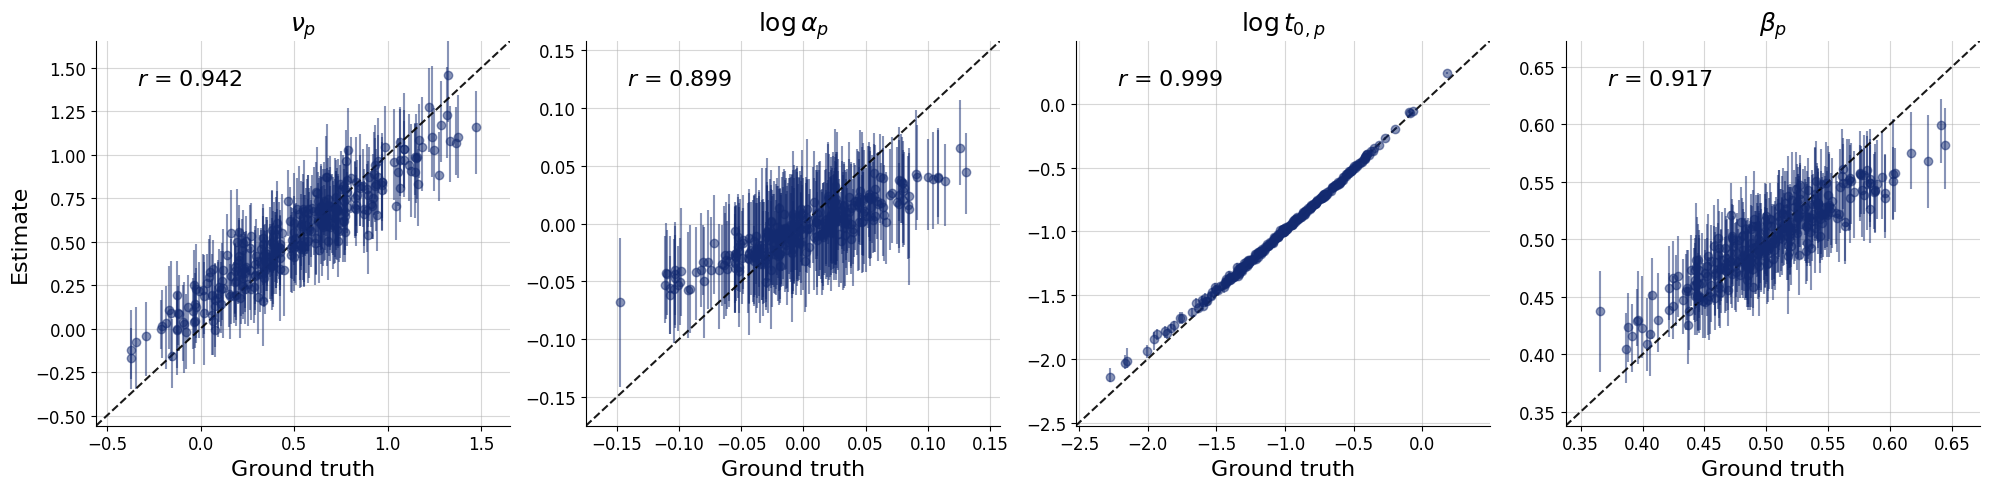

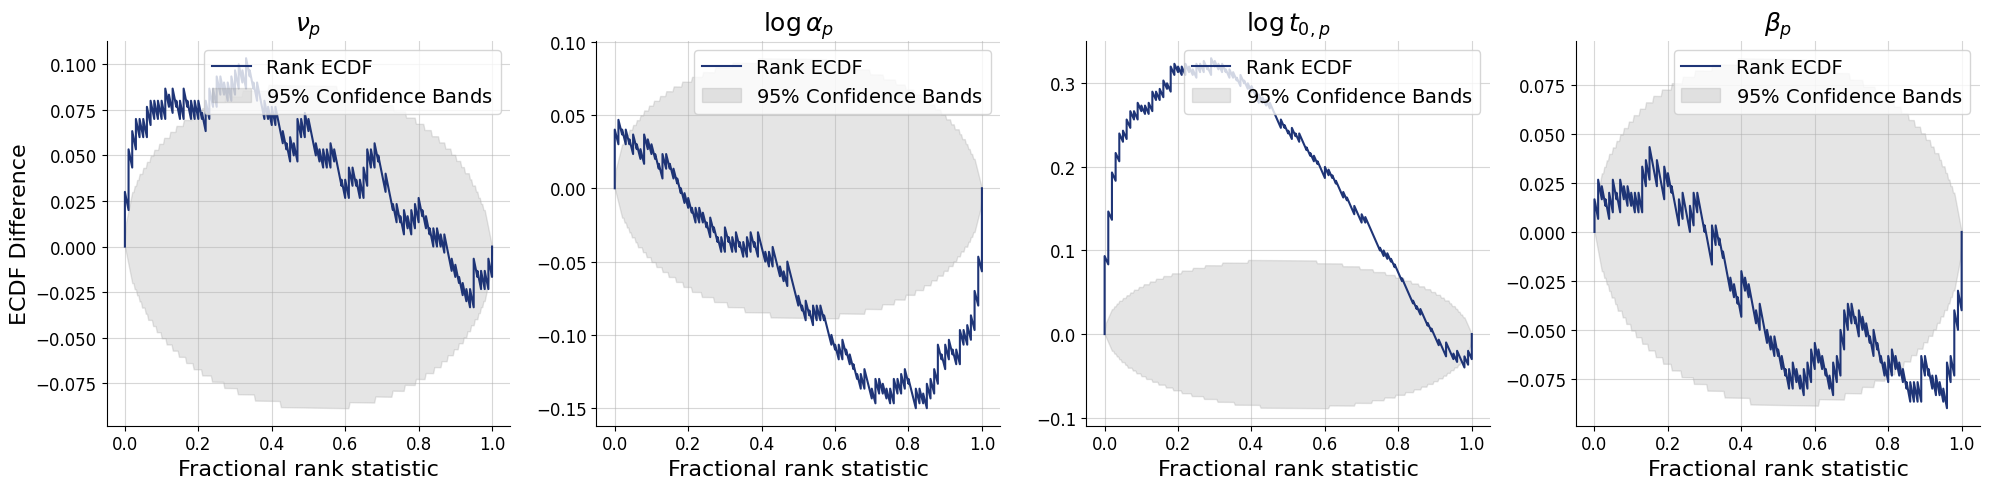

In [59]:
fig = bf.diagnostics.recovery(
    estimates=test_posterior_comp_subjects,
    targets=test_data_comp_subjects,
    variable_names=pretty_param_names_p
)
#fig.savefig(f"{storage}plots/complete_pooling_recovery_{few_trials}.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=test_posterior_comp_subjects,
    targets=test_data_comp_subjects,
    difference=True,
    variable_names=pretty_param_names_p
)
# fig.savefig(f"{storage}plots/complete_pooling_calibration.png")

In [60]:
test_posterior_comp_subjects['alpha'] = np.exp(test_posterior_comp_subjects['log_alpha'])
test_posterior_comp_subjects['t0'] = np.exp(test_posterior_comp_subjects['log_t0'])
metrics = {
    'NRMSE': bf.diagnostics.metrics.root_mean_squared_error(test_posterior_comp_subjects, test_data_comp_subjects)['values'][[0,4,5,3]],
    'calibration_error': bf.diagnostics.metrics.calibration_error(test_posterior_comp_subjects, test_data_comp_subjects)['values'][[0,4,5,3]],
    'calibration_log_gamma': bf.diagnostics.metrics.calibration_log_gamma(test_posterior_comp_subjects, test_data_comp_subjects)['values'][[0,4,5,3]],
}

with open(f'complete_pooling_subjects_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
metrics

{'NRMSE': VariableArray([0.09859075, 0.13734688, 0.00858409, 0.10240664]),
 'calibration_error': VariableArray([0.0595614 , 0.10666667, 0.1995614 , 0.06412281]),
 'calibration_log_gamma': array([ -5.74989311, -18.74808441,         -inf, -10.19687799])}